<a href="https://colab.research.google.com/github/bonareri/Machine_Learning_1/blob/main/Customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Prediction and Retention Strategy Optimization**

## Loading Libraries

In [116]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures

# Class Imbalance
from imblearn.over_sampling import SMOTE

# CV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Machine Learning Model Evaluation Methods
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import classification_report


warnings.filterwarnings(action="ignore")
%matplotlib inline

## Loading Data

In [89]:
# Load the uploaded dataset
customer_churn = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [90]:
customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## DATA CLEANING

In [91]:
# Drop unnesecary columns
customer_churn.drop(columns=['customerID'], inplace=True)

In [92]:
#Convert TotalCharges to numeric:
customer_churn['TotalCharges'] = pd.to_numeric(customer_churn['TotalCharges'], errors='coerce')

In [93]:
customer_churn['TotalCharges'].fillna(customer_churn['TotalCharges'].median(), inplace=True)

##Exploratory Data Analysis (EDA)

### Pairplot for selected features and the target variable

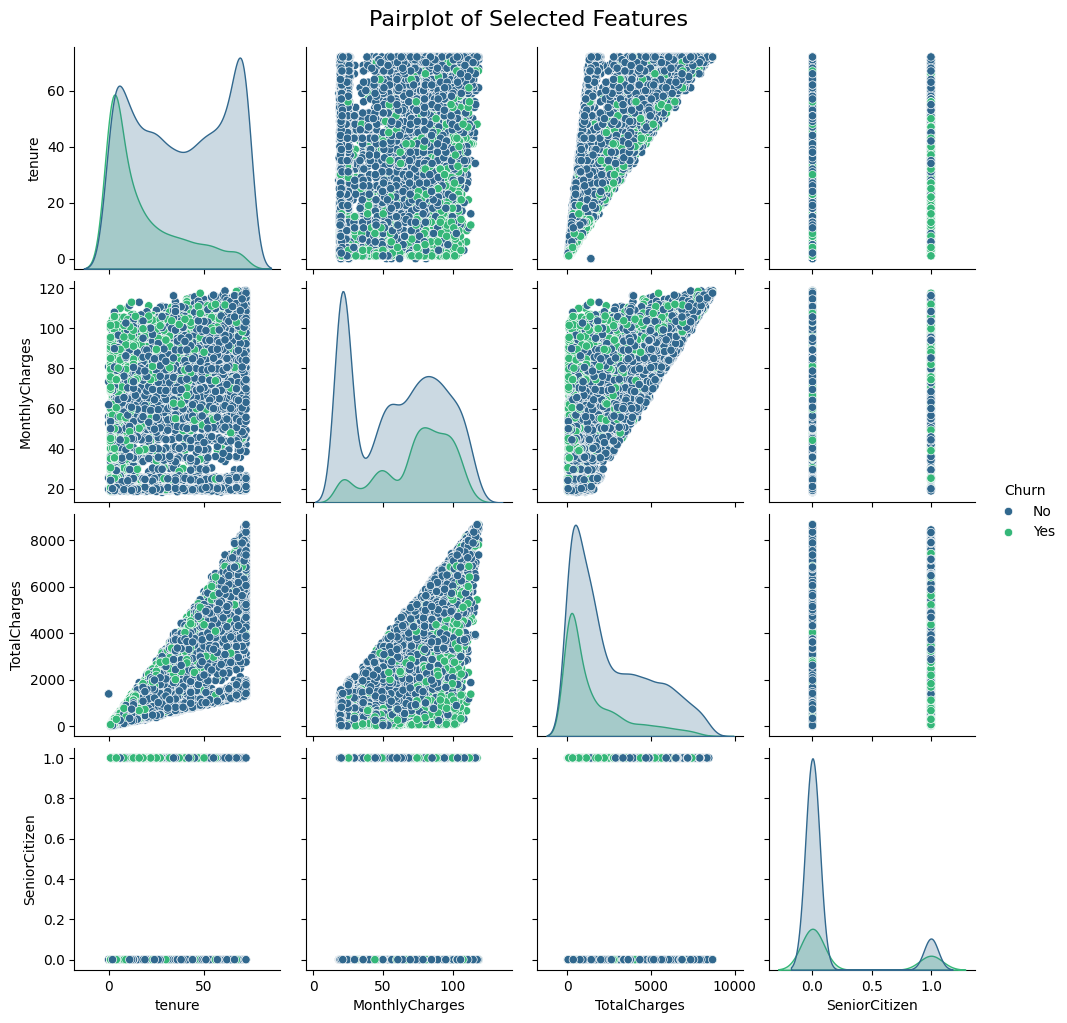

In [76]:
selected_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
sns.pairplot(customer_churn[selected_features + ['Churn']], hue='Churn', palette="viridis", diag_kind="kde")
plt.suptitle("Pairplot of Selected Features", fontsize=16, y=1.02)
plt.show()

Churn
No     5174
Yes    1869
Name: count, dtype: int64


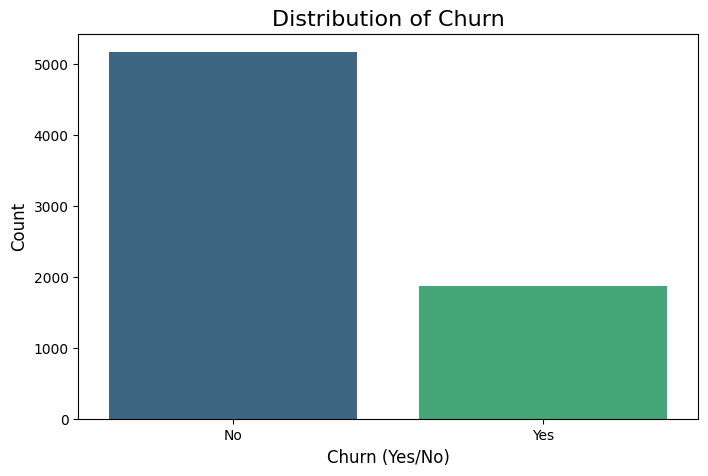

In [78]:
# Check the value counts for the 'Churn' column
churn_counts = customer_churn['Churn'].value_counts()
print(churn_counts)

# Bar plot to visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=customer_churn, x='Churn', palette="viridis")
plt.title("Distribution of Churn", fontsize=16)
plt.xlabel("Churn (Yes/No)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

### Encode Categorical Variables

In [98]:
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Apply one-hot encoding
customer_churn_encoded = pd.get_dummies(customer_churn, columns=categorical_cols, drop_first=True)

# Check the data types again
print(customer_churn_encoded.dtypes)

SeniorCitizen                              int64
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                     object
gender_Male                                 bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes     

In [100]:
# Convert the 'Churn' column to numeric (1 for 'Yes', 0 for 'No')
customer_churn_encoded['Churn'] = customer_churn_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Convert boolean columns to integers (0 or 1)
customer_churn_encoded = customer_churn_encoded.astype(int)

# Check the data types again to confirm the conversion
print(customer_churn_encoded.dtypes)

SeniorCitizen                            int64
tenure                                   int64
MonthlyCharges                           int64
TotalCharges                             int64
Churn                                    int64
gender_Male                              int64
Partner_Yes                              int64
Dependents_Yes                           int64
PhoneService_Yes                         int64
MultipleLines_No phone service           int64
MultipleLines_Yes                        int64
InternetService_Fiber optic              int64
InternetService_No                       int64
OnlineSecurity_No internet service       int64
OnlineSecurity_Yes                       int64
OnlineBackup_No internet service         int64
OnlineBackup_Yes                         int64
DeviceProtection_No internet service     int64
DeviceProtection_Yes                     int64
TechSupport_No internet service          int64
TechSupport_Yes                          int64
StreamingTV_N

## Model Building

### Splitting Data

In [107]:
# Define X (features) and y (target variable)
X = customer_churn_encoded.drop(['Churn'], axis=1)
y = customer_churn_encoded['Churn']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Verify the shape of the split data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5634, 30)
X_test shape: (1409, 30)
y_train shape: (5634,)
y_test shape: (1409,)


## Handling the Class Imbalance

In [109]:
#Encode the target variable 'Churn' using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify the shapes of the resampled training data
print(f"Original X_train shape: {X_train.shape}")
print(f"Resampled X_train shape: {X_train_res.shape}")
print(f"Original y_train shape: {y_train.shape}")
print(f"Resampled y_train shape: {y_train_res.shape}")

Original X_train shape: (5634, 30)
Resampled X_train shape: (8276, 30)
Original y_train shape: (5634,)
Resampled y_train shape: (8276,)


### Model Training

In [110]:
# Support vector classification - RBF Kernel
pipe = make_pipeline(PolynomialFeatures(degree=1), SVC(kernel='rbf', C=25))
# Use the resampled data from SMOTE for cross-validation
scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring="accuracy")
# Print the scores and the mean score
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.71799517 0.71601208 0.6978852  0.7305136  0.73776435]
Mean cross-validation score: 0.7200340791336457


In [111]:
# Classification - Random Forest
pipe = make_pipeline(PolynomialFeatures(degree=1), RandomForestClassifier(n_estimators=1000, max_depth=100, criterion='entropy'))

# Use the resampled data from SMOTE for cross-validation
scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring="accuracy")

# Print the scores and the mean score
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.72342995 0.76797583 0.9021148  0.89244713 0.88942598]
Mean cross-validation score: 0.8350787395828773


## Use the Model for New Test Cases

In [112]:
# Train model on train data
model = RandomForestClassifier(n_estimators=1000,random_state=10,criterion='gini',max_depth = 100)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=10)

In [113]:
# Use the model to define new classes / test data on which the model has not been trained.
yhat = model.predict(X_test)

# Evaluate our model
print("Train set Accuracy: ", accuracy_score(y_train, model.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Train set Accuracy:  0.9909478168264111
Test set Accuracy:  0.794180269694819


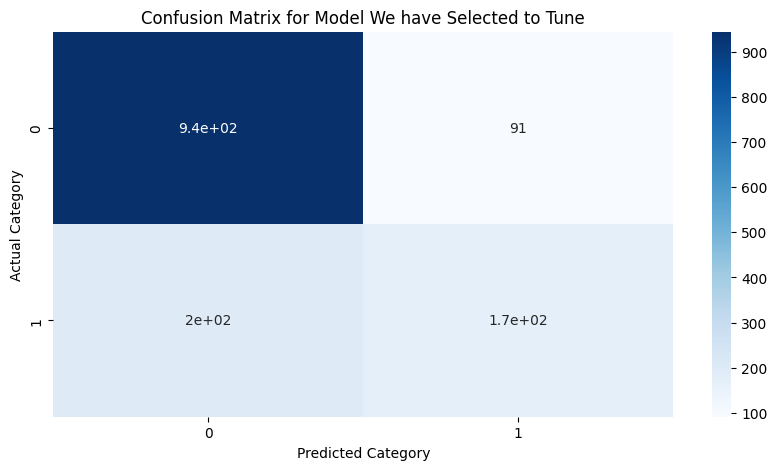

array([[945,  91],
       [199, 174]])

In [114]:
matrix = confusion_matrix(y_test, yhat)

#Visualise the matrix
plt.figure(figsize=(10,5))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Model We have Selected to Tune")
plt.show()

matrix

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 500],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")